In [3]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from zipfile import ZipFile
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

In [8]:
df = pd.read_csv('/content/IMDB Dataset.csv')
print(df.head())

# Map sentiment labels to numerical values
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})

print("\nSentiment value counts (1: positive, 0: negative):")
print(df['sentiment'].value_counts())

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive

Sentiment value counts (1: positive, 0: negative):
sentiment
1    25000
0    25000
Name: count, dtype: int64


In [9]:
df.replace({"sentiment": {"positive": 1, "negative": 0}}, inplace=True)

In [10]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [11]:
# Step 1: Split 80% train, 20% temp (val+test)
data = df
train, temp = train_test_split(data, test_size=0.20, random_state=42, stratify=data['sentiment'])

# Step 2: Split 20% temp into 10% val and 10% test (i.e., 50% of temp each)
val, test = train_test_split(temp, test_size=0.50, random_state=42, stratify=temp['sentiment'])

# Check proportions
print(f"Train: {len(train)}, Val: {len(val)}, Test: {len(test)}")

Train: 40000, Val: 5000, Test: 5000


In [12]:
train_data = train
val_data = val
test_data = test

print(train_data.shape)
print(test_data.shape)
print(val_data.shape)

(40000, 2)
(5000, 2)
(5000, 2)


In [13]:
# Tokenize text data
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(train_data["review"])
# Convert text to sequences and pad
X_train = pad_sequences(tokenizer.texts_to_sequences(train_data["review"]), maxlen=200)
X_val = pad_sequences(tokenizer.texts_to_sequences(val_data["review"]), maxlen=200)
X_test = pad_sequences(tokenizer.texts_to_sequences(test_data["review"]), maxlen=200)

# Target variables
Y_train = train_data["sentiment"].values
Y_val = val_data["sentiment"].values
Y_test = test_data["sentiment"].values

In [14]:
# Build the model
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=200))
model.add(LSTM(units=64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(units=1, activation='sigmoid'))



# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Early Stopping Callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    X_train, Y_train,
    epochs=8,
    batch_size=64,
    validation_data=(X_val, Y_val),
    callbacks=[early_stopping]
)

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/8
625/625 ━━━━━━━━━━━━━━━━━━━━ 235s 362ms/step - accuracy: 0.7379 - loss: 0.5206 - val_accuracy: 0.8492 - val_loss: 0.3536
Epoch 2/8
625/625 ━━━━━━━━━━━━━━━━━━━━ 258s 363ms/step - accuracy: 0.8532 - loss: 0.3549 - val_accuracy: 0.8606 - val_loss: 0.3401
Epoch 3/8
625/625 ━━━━━━━━━━━━━━━━━━━━ 259s 358ms/step - accuracy: 0.8807 - loss: 0.2970 - val_accuracy: 0.8748 - val_loss: 0.2881
Epoch 4/8
625/625 ━━━━━━━━━━━━━━━━━━━━ 265s 363ms/step - accuracy: 0.8859 - loss: 0.2795 - val_accuracy: 0.8816 - val_loss: 0.2875
Epoch 5/8
625/625 ━━━━━━━━━━━━━━━━━━━━ 262s 363ms/step - accuracy: 0.9121 - loss: 0.2250 - val_accuracy: 0.8850 - val_loss: 0.2804
Epoch 6/8
625/625 ━━━━━━━━━━━━━━━━━━━━ 228s 365ms/step - accuracy: 0.9221 - loss: 0.2020 - val_accuracy: 0.8860 - val_loss: 0.2870
Epoch 7/8
625/625 ━━━━━━━━━━━━━━━━━━━━ 257s 358ms/step - accuracy: 0.9269 - loss: 0.1861 - val_accuracy: 0.8902 - val_loss: 0.2974
Epoch 8/8
625/625 ━━━━━━━━━━━━━━━━━━━━ 266s 364ms/step - accuracy: 0.9419 - loss: 0

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (64, 200, 128)         │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (64, 64)               │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (64, 1)                │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,068,421 (7.89 MB)

 Trainable params: 689,473 (2.63 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,378,948 (5.26 MB)

In [16]:
from tensorflow.keras.models import load_model
loss, accuracy = model.evaluate(X_test, Y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 17s 107ms/step - accuracy: 0.8910 - loss: 0.2749
Test Loss: 0.2919
Test Accuracy: 0.8848


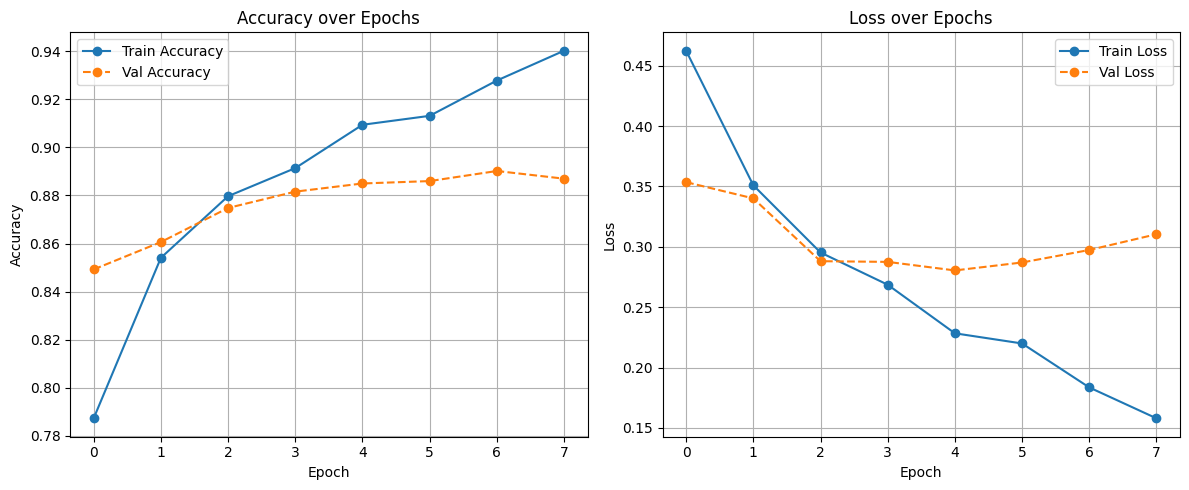

In [17]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', linestyle='--', marker='o')  # Dotted line
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', linestyle='--', marker='o')  # Dotted line
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


157/157 ━━━━━━━━━━━━━━━━━━━━ 17s 107ms/step


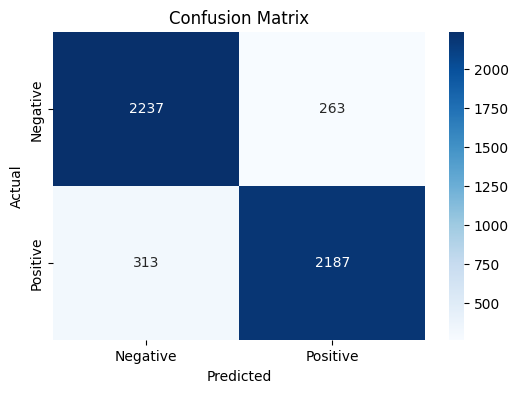

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on test data
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype("int32")

# Create confusion matrix
cm = confusion_matrix(Y_test, y_pred)

# Display with seaborn heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()



In [19]:
def predict_sentiment(review):
    # Preprocess the review
    review = review.lower().strip()
    # Tokenize and pad
    sequence = tokenizer.texts_to_sequences([review])
    padded_sequence = pad_sequences(sequence, maxlen=200)
    # Predict sentiment
    prediction = model.predict(padded_sequence)
    prob = prediction[0][0]
    sentiment = "positive" if prob > 0.5 else "negative"
    return sentiment, prob

In [20]:
# Example usage
new_review = "This movie was fantastic. I loved it."
sentiment, confidence = predict_sentiment(new_review)
print(f"The sentiment of the review is: {sentiment} (confidence: {confidence:.2f})")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
The sentiment of the review is: positive (confidence: 0.97)
